In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
from scipy.constants import pi
from scipy.misc import imread
import numpy as np
import imageio

%matplotlib inline

In [2]:
w, h = 1920, 1080
dpi = 200

In [3]:
# calculate centers of zones L, C, R (left, center, right)

i_c_C = w//2
j_c_C = w//4
centers = [
    ('L', (w/4, w/2), -pi/2),
    ('C', (i_c_C, j_c_C), 0.),
    ('R', (3.*w/4, w/2), pi/2),
]

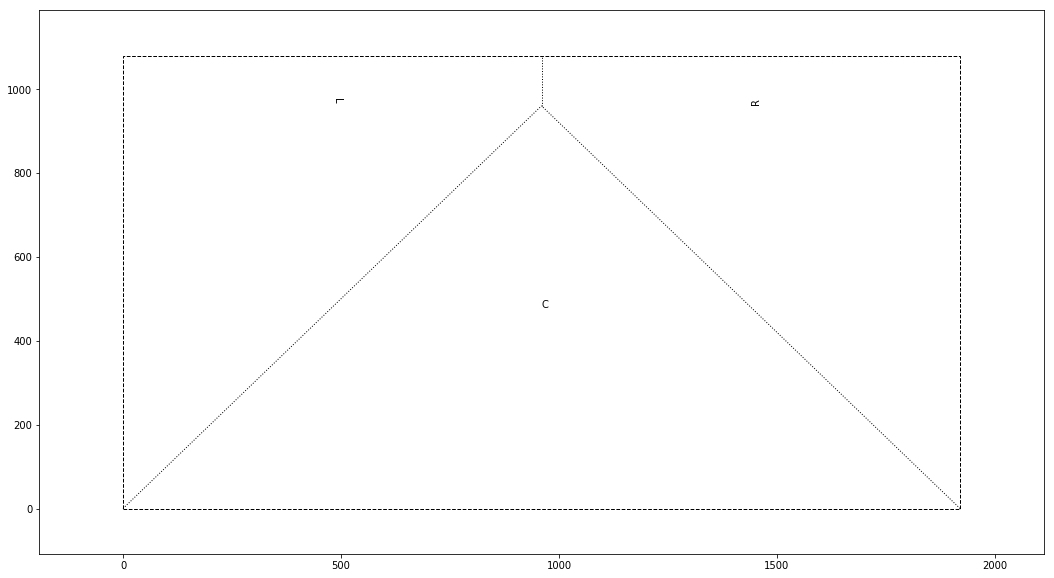

In [16]:
def make_screen_fig():
    return plt.subplots(figsize=(w/dpi*2, h/dpi*2))


def plot_screen(ax=None, color='black'):
    if ax is None:
        fig, ax = make_screen_fig()

    screen_patch = patches.Rectangle((0, 0), w, h, linewidth=1, facecolor='none', edgecolor=color, linestyle='--')

    # the seperating line appears to be at 45 deg to x-axis, and so separating line must end at h=w/2
    sep_left = mlines.Line2D((0, w/2), (0, w/2), linewidth=1, linestyle=':', color=color)
    sep_right = mlines.Line2D((w, w/2), (0, w/2), linewidth=1, linestyle=':', color=color)
    sep_center = mlines.Line2D((w/2, w/2), (w/2, h), linewidth=1, linestyle=':', color=color)



    for name, pt, rot in centers:
        #plt.plot(pt[0], pt[1], marker='x')
        plt.text(pt[0], pt[1], name, rotation=rot*180./pi, color=color)
        #plt.text(100, 100, name, fontsize=0.1)

    ax.add_patch(screen_patch)
    ax.add_line(sep_left)
    ax.add_line(sep_right)
    ax.add_line(sep_center)

    ax.set_xlim(-0.1*w, 1.1*w)
    ax.set_ylim(-0.1*h, 1.1*h)
    
    return ax
plot_screen()

In [46]:
img_L = np.transpose(imageio.imread('../examples/text_LEFT.png'), axes=(1,0,2))

In [18]:
n_colors = img_L.shape[-1]

In [34]:
def plot_img(img, **kwargs):
    plt.imshow(np.transpose(img, axes=(1,0,2)), **kwargs)

(400, 400, 4)

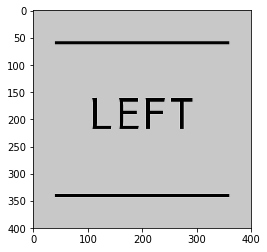

In [35]:
plot_img(img_L)
img_L.shape

In [36]:
h - img_L.shape[0]

680

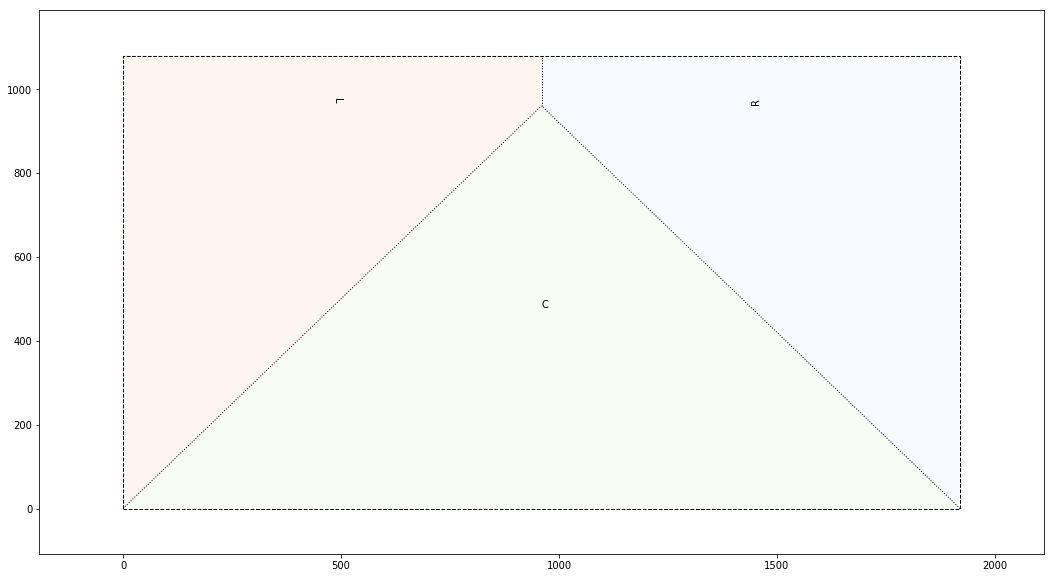

In [33]:
# to insert image at right place need to transpose, clip and do a asked insert into final image
i, j = np.arange(w), np.arange(h)
i_, j_ = np.meshgrid(i, j, indexing='ij')
mask_L = np.logical_and(j_ > i_, i_ < w/2)
mask_R = np.logical_and(j_ > (w - i_), i_ > w/2)
mask_C = np.logical_and(np.logical_not(mask_L), np.logical_not(mask_R))


ax = plot_screen()
ax.pcolormesh(i_, j_, np.ma.masked_array(mask_L, ~mask_L), cmap='Reds', alpha=0.5)
ax.pcolormesh(i_, j_, np.ma.masked_array(mask_R, ~mask_R), cmap='Blues', alpha=0.5)
ax.pcolormesh(i_, j_, np.ma.masked_array(mask_C, ~mask_C), cmap='Greens', alpha=0.5)

((1920, 1080, 4), (1920, 1080, 4))
(1920, 1080)
(1920, 1080, 4)


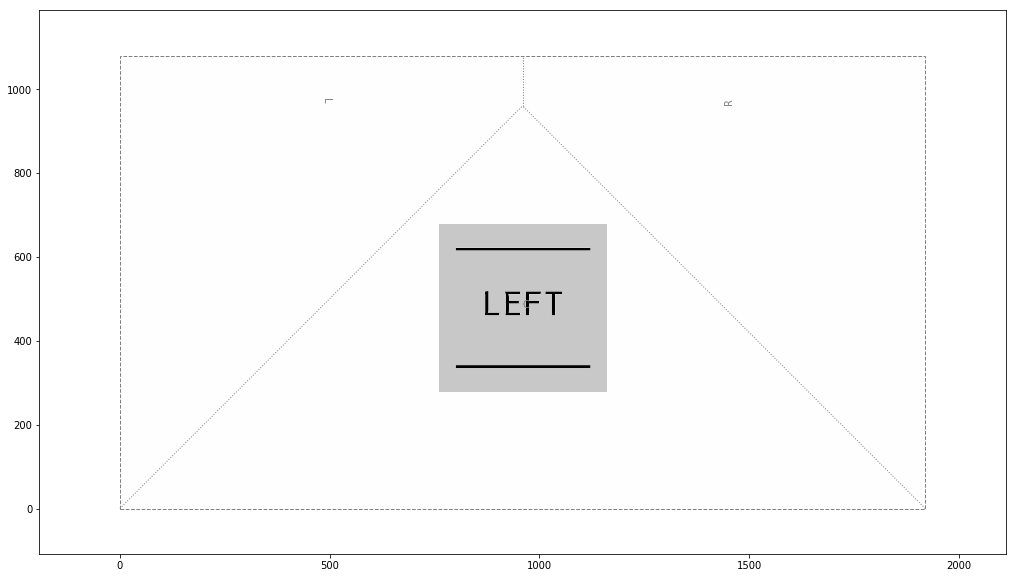

In [39]:
# place central image
img_in = img_L
img_output = np.ones((w, h, n_colors)).astype(img_in.dtype)

# flip image in y-direction, indexing from top-left by default
img_in = np.flip(img_in, axis=1)


w_in, h_in, _ = img_in.shape

# ensure we have a minimum an image the size of the output
w_min, h_min = max(w_in, w), max(h_in, h)
img_ = np.ones((w_min, h_min, n_colors)).astype(img_in.dtype)
img_[:w_in, :h_in] = img_in

# center on 0,0
img_ = np.roll(np.roll(img_, -w_in//2, axis=0), -h_in//2, axis=1)

# center on the C's center
img_ = np.roll(np.roll(img_, i_c_C, axis=0), j_c_C, axis=1)
# crop to the final image's extent
img_ = img_[:w,:h]
# the image we've put in might actually be smaller in extent
# than the final image so we may have to offset it when we insert
w_cropped, h_cropped, _ = img_.shape

i_min, i_max = max(0, w//2-w_cropped//2), min(w, w//2+w_cropped//2)
j_min, j_max = max(0, w//4-h_cropped//2), min(w, w//4+h_cropped//2)

print(img_.shape, img_output.shape)
print(mask_C.shape)

img_output[mask_C] = img_[mask_C]

print(img_output.shape)

fig, ax = make_screen_fig()
plot_img(img_output)
plot_screen(plt.gca(), color='grey')

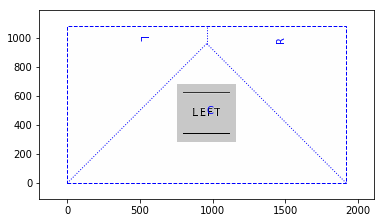

In [41]:
def _center_image(img):
    img_in = img_L
    
    # flip image in y-direction, indexing from top-left by default
    img_in = np.flip(img_in, axis=1)

    w_in, h_in, _ = img_in.shape

    # ensure we have a minimum an image the size of the output
    w_min, h_min = max(w_in, w), max(h_in, h)
    img_ = np.ones((w_min, h_min, n_colors)).astype(img_in.dtype)
    img_[:w_in, :h_in] = img_in

    # center on 0,0
    img_ = np.roll(np.roll(img_, -w_in//2, axis=0), -h_in//2, axis=1)

    # center on the C's center
    img_ = np.roll(np.roll(img_, i_c_C, axis=0), j_c_C, axis=1)
    
    # crop to the final image's extent
    img_ = img_[:w,:h]
    
    return img_

def place_central_image(img, img_output):
    img_output = np.ones((w, h, n_colors)).astype(img.dtype)

    img_ = _center_image(img)
    img_output[mask_C] = img_[mask_C]
    
    return img_output

img_output = np.ones((w, h, n_colors)).astype(img_in.dtype)
img_output = place_central_image(img_in, img_output)
plot_img(img_output)
plot_screen(plt.gca(), color='blue')

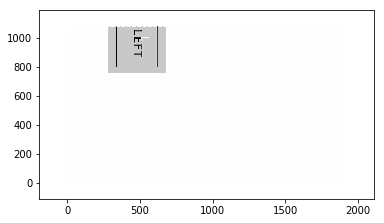

In [42]:
def place_left_img(img, img_output):
    img_ = _center_image(img_in)
    img_ = np.rot90(img_, axes=(1,0))[:,:h]

    # need to crop the mask before we apply it
    m = mask_L[:h]
    img_output[:h][m] = img_[m]
    
    return img_output


img_output = np.ones((w, h, n_colors)).astype(img_in.dtype)
img_output = place_left_img(img_in, img_output)
plot_img(img_output)
plot_screen(plt.gca(), color='white')

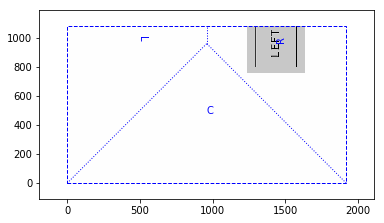

In [43]:
def place_right_img(img, img_output):
    img_ = _center_image(img_in)
    
    img_ = np.rot90(img_, axes=(1,0), k=-1)
        
    w_ = img_.shape[0]

    img_temp = np.zeros_like(img_output)
    img_temp[:w_] = img_[:w_,:h]
    img_temp = np.roll(img_temp, axis=0, shift=w-w_)

    img_output[mask_R] = img_temp[mask_R]

    return img_output

img_output = np.ones((w, h, n_colors)).astype(img_in.dtype)
img_output = place_right_img(img_in, img_output)
plot_img(img_output)
plot_screen(plt.gca(), color='blue')

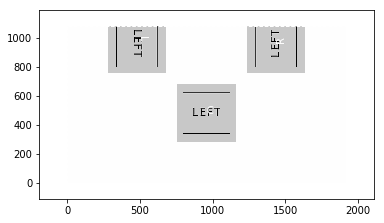

In [44]:
img_output = np.ones((w, h, n_colors)).astype(img_in.dtype)

img_output = place_central_image(img_in, img_output)
img_output = place_left_img(img_in, img_output)
img_output = place_right_img(img_in, img_output)

plot_img(img_output)
plot_screen(plt.gca(), color='white')
imageio.imwrite('combined_example.png', np.rot90(img_output, k=1))

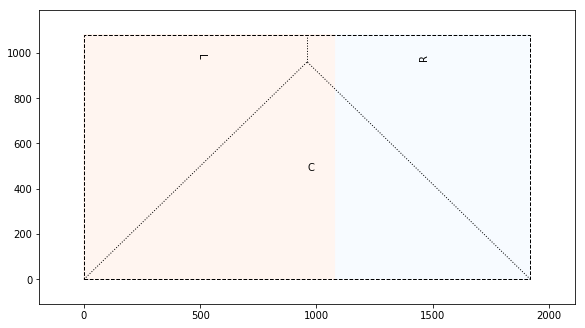

In [16]:
# to insert image at right place need to transpose, clip and do a asked insert into final image
i, j = np.arange(w), np.arange(h)
i_, j_ = np.meshgrid(i, j)
square_L = i_ < h
square_R = i_ > h

ax = plot_screen()
ax.pcolormesh(i_, j_, np.ma.masked_array(square_L, ~square_L), cmap='Reds', alpha=0.5)
ax.pcolormesh(i_, j_, np.ma.masked_array(square_R, ~square_R), cmap='Blues', alpha=0.5)

In [17]:
# L
i_min = w - h
img_L_t = np.transpose(img_L[:, i_min:], axes=(1,0,2))

(141, 1920, 4)

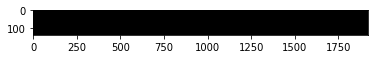

In [18]:
plt.imshow(img_L_t)
img_L_t.shape

In [19]:
img_output = np.empty((h, w, n_colors))